In [1]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
import json

class PolygonDataset(Dataset):
    def __init__(self, input_dir, output_dir, json_file, color_to_idx, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.json_file = json_file
        self.color_to_idx = color_to_idx
        self.transform = transform
        
        self.data = []
        
        # Load JSON directly
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Iterate through the JSON list and build the dataset
        for entry in data:
            input_polygon = entry['input_polygon']
            color = entry['colour']
            output_image = entry['output_image']
            
            input_path = os.path.join(input_dir, input_polygon)
            output_path = os.path.join(output_dir, output_image)
            
            # Check if both input and output images exist
            if os.path.exists(input_path) and os.path.exists(output_path):
                self.data.append((input_path, output_path, color))
            else:
                print(f"Skipping: {input_path} or {output_path} does not exist")
        
        print(f"Total pairs loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_path, output_path, color = self.data[idx]
    
        # Open the input image as binary (1 channel)
        input_image = Image.open(input_path).convert('L')  # 'L' for grayscale (binary)
        
        # Open the output image as RGB (3 channels)
        output_image = Image.open(output_path).convert('RGB')
        
        # Apply transformations if defined
        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)
    
        # Convert color to index
        color_idx = self.color_to_idx[color]
        
        # One-hot encoding the color (8 classes, including blue)
        one_hot_color = torch.zeros(8)  # Update to 8 classes based on color_to_idx
        one_hot_color[color_idx] = 1
        
        # Reshape the one_hot_color to (8, 128, 128) to match the image dimensions
        one_hot_color = one_hot_color.view(8, 1, 1).expand(8, 128, 128)  # Now it has the shape (8, 128, 128)
    
        # Convert the input image to a 128x128 binary array (1 channel)
        input_image = np.array(input_image).reshape(1, 128, 128)  # (128, 128) -> (1, 128, 128)
        
        # Convert the output image to a 3x128x128 array (3 channels)
        output_image = np.array(output_image).transpose(2, 0, 1)  # (128, 128, 3) -> (3, 128, 128)
        
        # Convert to tensors
        input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0  # Normalize binary values to [0, 1]
        output_image = torch.tensor(output_image, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        
        # Concatenate color (one-hot encoded), input image, and output image along the first dimension
        return torch.cat((one_hot_color, input_image, output_image), dim=0)  # Shape: (8, 128, 128) + (1, 128, 128) + (3, 128, 128)

# Define the color to index mapping (this can be based on your color set)
color_to_idx = {
    'cyan': 0, 'red': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'yellow': 5, 'purple': 6, 'blue': 7
}

# Path to the JSON file and directories
json_file = '/home/vivek-vardhan/AV/dataset/dataset/training/data.json'
input_folder = "/home/vivek-vardhan/AV/dataset/dataset/training/inputs/"
output_folder = "/home/vivek-vardhan/AV/dataset/dataset/training/outputs/"

# Initialize the dataset
train_dataset = PolygonDataset(input_folder, output_folder, json_file, color_to_idx, transform=None)

# Sample usage: Get the first sample in the dataset
sample = train_dataset[0]

# Print the shape of the sample
print(f"Shape of the sample: {sample.shape}")


Total pairs loaded: 56
Shape of the sample: torch.Size([12, 128, 128])


In [3]:
print(f"Length of training dataset:{len(train_dataset)}")
print(f"Length of one training dataset sample:{len(train_dataset[0])}")

Length of training dataset:56
Length of one training dataset sample:12


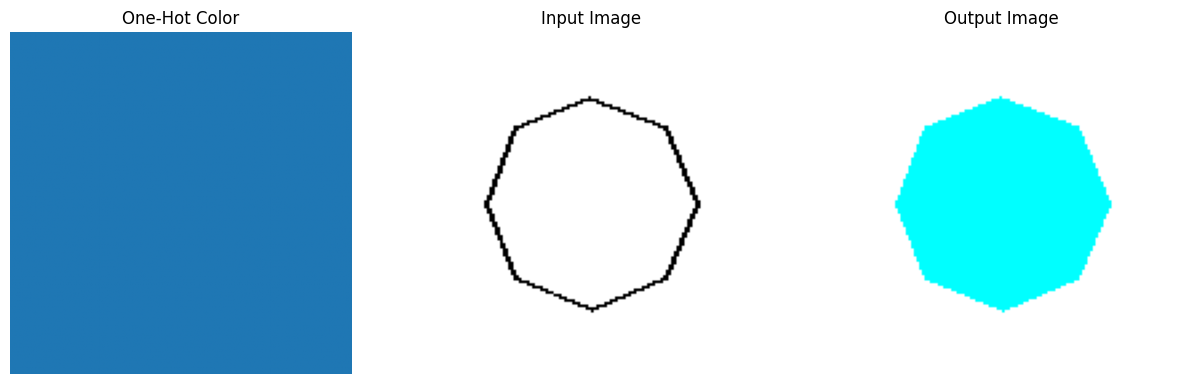

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get the first sample from the dataset
sample = train_dataset[0]

# Extract the one-hot encoded color, input image, and output image
one_hot_color = sample[:8, :, :]  # The first 8 channels are the one-hot encoded color (since color_to_idx has 8 classes now)
input_image = sample[8:9, :, :]   # The next channel is the input image (1 channel)
output_image = sample[9:, :, :]   # The next 3 channels are the output image (3 channels)

# Convert to numpy for display
one_hot_color = one_hot_color.numpy()  # (8, 128, 128)
input_image = input_image.numpy().squeeze()  # Convert to numpy and remove singleton dimensions
output_image = output_image.numpy().transpose(1, 2, 0)  # Convert to (128, 128, 3) for RGB

# Visualize the first non-zero channel of one-hot encoded color
# Find the first channel where the value is 1 (non-zero)
active_color_channel = np.argmax(one_hot_color, axis=0)  # This gives a 128x128 array with values from 0 to 7

# Plot the images using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the one-hot color (display the active channel as a binary image)
axes[0].imshow(active_color_channel, cmap='tab10')  # Use 'tab10' colormap to show the active color channel
axes[0].set_title("One-Hot Color")
axes[0].axis('off')

# Display the input image (grayscale)
axes[1].imshow(input_image, cmap='gray')
axes[1].set_title("Input Image")
axes[1].axis('off')

# Display the output image (RGB)
axes[2].imshow(output_image)
axes[2].set_title("Output Image")
axes[2].axis('off')

plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=9, out_channels=3):
        super(UNet, self).__init__()

        # Encoder (input channels = 12, output channels = 64, 128, 256)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Decoder (reverse the encoder channels)
        self.dec1 = self.upconv_block(256, 128)
        self.dec2 = self.upconv_block(128, 64)
        
        # Final Convolution Layer to output RGB (3 channels)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder Path
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        
        # Decoder Path
        dec1 = self.dec1(enc3)
        dec2 = self.dec2(dec1)
        
        # Final Convolution (to get 3 channels: RGB)
        out = self.final_conv(dec2)

        # Apply Sigmoid to ensure the output is in [0, 1] (for RGB images)
        out = torch.sigmoid(out)  # Use this if your output values are normalized to [0, 1]

        return out

    def conv_block(self, in_channels, out_channels):
        """Convolution block: Conv -> ReLU -> Conv -> ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block: ConvTranspose -> ReLU"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn

# Define the U-Net model (already defined previously)
model = UNet(in_channels=9, out_channels=3)  # 7 classes for the one-hot encoded color

# Move model to GPU if available
device = torch.device('cpu')
model = model.to(device)

# Define loss function (CrossEntropyLoss)
# CrossEntropyLoss expects the target to be a 2D tensor with class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optional: Define a learning rate scheduler (for better learning rate management)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Now, when training, you would call scheduler.step() at the end of each epoch


In [15]:
import wandb

# Training parameters
EPOCHS = 10
BATCH_SIZE = 12
LEARNING_RATE = 10

wandb.init(
    project="ayna-polygon-coloring",  # or any custom project name
    name="unet-coloring-run-1",        # optional: to track specific runs
    config={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "optimizer": "Adam",
        "loss_fn": "MSELoss",
        "architecture": "UNet",
        "condition_vector": "one-hot (10 classes)",
    }
)

In [16]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Training parameters
epochs = 10
batch_size = 12

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define loss function (Mean Squared Error for pixel-wise color regression)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        # Unpack the data
        one_hot_color = data[:, :8, :, :].to(device)  # First 8 channels: One-hot encoded color
        input_image = data[:, 8:9, :, :].to(device)   # 9th channel: Input image
        output_image = data[:, 9:, :, :].to(device)    # Remaining channels: Color-filled polygon image

        # Concatenate the one-hot color (8 channels) and input image (1 channel)
        model_input = torch.cat((one_hot_color, input_image), dim=1)  # Shape: [batch_size, 9, H, W]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_pred = model(model_input)  # Model output: [batch_size, 3, 128, 128] (RGB color image)

        # Resize the model output to match the target dimensions (128x128)
        outputs_pred_resized = F.interpolate(outputs_pred, size=(128, 128), mode='bilinear', align_corners=True)

        # Compute the loss: MSELoss expects both predictions and targets to have the same shape
        loss = criterion(outputs_pred_resized, output_image)  # Compare RGB images

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 batches
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 10:.4f}")
            running_loss = 0.0
    
    print(f"Epoch {epoch+1}/{epochs} finished.")

# Optionally, save the model after training
torch.save(model.state_dict(), '/home/vivek-vardhan/AV/model/model_final.pth')


Epoch 1/10 finished.
Epoch 2/10 finished.
Epoch 3/10 finished.
Epoch 4/10 finished.
Epoch 5/10 finished.
Epoch 6/10 finished.
Epoch 7/10 finished.
Epoch 8/10 finished.
Epoch 9/10 finished.
Epoch 10/10 finished.


In [17]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
import json

class PolygonDatasetValidation(Dataset):
    def __init__(self, input_dir, output_dir, json_file, color_to_idx, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.json_file = json_file
        self.color_to_idx = color_to_idx
        self.transform = transform
        
        self.data = []
        
        # Load JSON directly
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Iterate through the JSON list and build the dataset
        for entry in data:
            input_polygon = entry['input_polygon']
            color = entry['colour']
            output_image = entry['output_image']
            
            input_path = os.path.join(input_dir, input_polygon)
            output_path = os.path.join(output_dir, output_image)
            
            # Check if both input and output images exist
            if os.path.exists(input_path) and os.path.exists(output_path):
                self.data.append((input_path, output_path, color))
            else:
                print(f"Skipping: {input_path} or {output_path} does not exist")
        
        print(f"Total pairs loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_path, output_path, color = self.data[idx]
    
        # Open the input image as binary (1 channel)
        input_image = Image.open(input_path).convert('L')  # 'L' for grayscale (binary)
        
        # Open the output image as RGB (3 channels)
        output_image = Image.open(output_path).convert('RGB')
        
        # Apply transformations if defined
        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)
    
        # Convert color to index
        color_idx = self.color_to_idx[color]
        
        # One-hot encoding the color (8 classes, including blue)
        one_hot_color = torch.zeros(8)  # Update to 8 classes based on color_to_idx
        one_hot_color[color_idx] = 1
        
        # Reshape the one_hot_color to (8, 128, 128) to match the image dimensions
        one_hot_color = one_hot_color.view(8, 1, 1).expand(8, 128, 128)  # Now it has the shape (8, 128, 128)
    
        # Convert the input image to a 128x128 binary array (1 channel)
        input_image = np.array(input_image).reshape(1, 128, 128)  # (128, 128) -> (1, 128, 128)
        
        # Convert the output image to a 3x128x128 array (3 channels)
        output_image = np.array(output_image).transpose(2, 0, 1)  # (128, 128, 3) -> (3, 128, 128)
        
        # Convert to tensors
        input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0  # Normalize binary values to [0, 1]
        output_image = torch.tensor(output_image, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
        
        # Concatenate color (one-hot encoded), input image, and output image along the first dimension
        return torch.cat((one_hot_color, input_image, output_image), dim=0)  # Shape: (8, 128, 128) + (1, 128, 128) + (3, 128, 128)

# Define the color to index mapping (this can be based on your color set)
color_to_idx = {
    'cyan': 0, 'red': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'yellow': 5, 'purple': 6, 'blue': 7
}

# Path to the JSON file and directories
json_file = '/home/vivek-vardhan/AV/dataset/dataset/validation/data.json'
input_folder = "/home/vivek-vardhan/AV/dataset/dataset/validation/inputs/"
output_folder = "/home/vivek-vardhan/AV/dataset/dataset/validation/outputs/"

# Initialize the dataset
validation_dataset = PolygonDatasetValidation(input_folder, output_folder, json_file, color_to_idx, transform=None)

# Sample usage: Get the first sample in the dataset
sample = validation_dataset[0]

# Print the shape of the sample
print(f"Shape of the sample: {sample.shape}")


Total pairs loaded: 5
Shape of the sample: torch.Size([12, 128, 128])


In [18]:
print(f"size of dataset:{len(validation_dataset)}")
for i in range(len(validation_dataset)):
    print(f"size of dataset:{validation_dataset[i].shape}")

size of dataset:5
size of dataset:torch.Size([12, 128, 128])
size of dataset:torch.Size([12, 128, 128])
size of dataset:torch.Size([12, 128, 128])
size of dataset:torch.Size([12, 128, 128])
size of dataset:torch.Size([12, 128, 128])


In [19]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_model(model, validation_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    confusion = np.zeros((8, 8))  # Confusion matrix for 8 classes (can be skipped for color regression)

    with torch.no_grad():  # No gradient computation for evaluation
        for data in validation_loader:
            one_hot_color = data[:, :8, :, :].to(device)  # First 8 channels: One-hot encoded color
            input_image = data[:, 8:9, :, :].to(device)   # 9th channel: Input image
            output_image = data[:, 9:, :, :].to(device)    # Remaining channels: Color-filled polygon image

            # Concatenate the one-hot color (8 channels) and input image (1 channel)
            model_input = torch.cat((one_hot_color, input_image), dim=1)  # Shape: [batch_size, 9, H, W]

            # Forward pass
            outputs_pred = model(model_input)  # Model output: [batch_size, 3, 128, 128] (RGB color image)

            # Resize the model output to match the target dimensions (128x128)
            outputs_pred_resized = F.interpolate(outputs_pred, size=(128, 128), mode='bilinear', align_corners=True)

            # Compute the loss: MSELoss for pixel-wise RGB values
            loss = criterion(outputs_pred_resized, output_image)
            running_loss += loss.item()

            # Since this is color prediction, confusion matrix and accuracy metrics aren't meaningful
            # We could compare pixel-wise similarity, PSNR, or SSIM instead if needed.

    # Calculate average loss
    avg_loss = running_loss / len(validation_loader)

    print(f"Validation Loss: {avg_loss:.4f}")

    return avg_loss

In [20]:
# Initialize validation loader
validation_loader = DataLoader(validation_dataset, batch_size=5, shuffle=False)

# Evaluate the model
avg_loss = evaluate_model(model, validation_loader, criterion, device)

Validation Loss: 0.0641


In [21]:
import torch
import torchvision.transforms as T

def calculate_psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100
    pixel_max = 1.0  # If images are normalized [0, 1]
    return 20 * torch.log10(pixel_max / torch.sqrt(mse))

# Inside the evaluation loop:
psnr = calculate_psnr(outputs_pred_resized, output_image)
print(f"PSNR: {psnr.item():.4f}")
    

PSNR: 9.8672


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

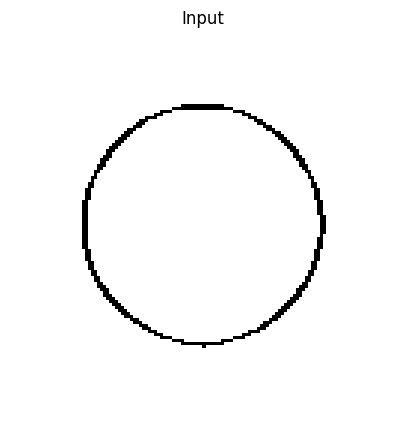

In [22]:
def inputFunction(color_to_idx, color, input_image):
    
    #########################################################
    input_image = Image.open(input_image).convert('L')  # 'L' for grayscale (binary)

    color_idx = color_to_idx[color]
    
    # One-hot encoding the color (8 classes, including blue)
    one_hot_color = torch.zeros(8)  # Update to 8 classes based on color_to_idx
    one_hot_color[color_idx] = 1
    
    # Reshape the one_hot_color to (8, 128, 128) to match the image dimensions
    one_hot_color = one_hot_color.view(8, 1, 1).expand(8, 128, 128)  # Now it has the shape (8, 128, 128)
    
    # Convert the input image to a 128x128 binary array (1 channel)
    input_image = np.array(input_image).reshape(1, 128, 128)  # (128, 128) -> (1, 128, 128)
    # Convert to tensors
    input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0  # Normalize binary values to [0, 1]

    model_input = torch.cat((one_hot_color, input_image), dim=0)
    # Concatenate color (one-hot encoded), input image, and output image along the first dimension
    return model_input  # Shape: (8, 128, 128) + (1, 128, 128) + (3, 128, 128)


color_to_idx = {
    'cyan': 0, 'red': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'yellow': 5, 'purple': 6, 'blue': 7
}

color = 'red'
input_path = "/home/vivek-vardhan/AV/dataset/dataset/training/inputs/circle.png"
input_image = Image.open(input_path).convert('L')
input_image = np.array(input_image).reshape(1, 128, 128)
input_image = torch.tensor(input_image, dtype=torch.float32) / 255.0
input_image = input_image.numpy().squeeze()
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Display the one-hot color (display the active channel as a binary image)
axes.imshow(input_image,cmap='grey')
axes.set_title("Input")
axes.axis('off')


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

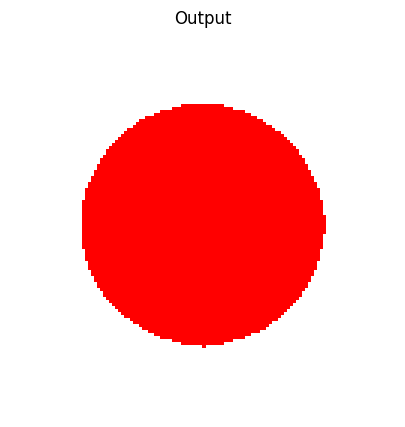

In [23]:
output_path = "/home/vivek-vardhan/AV/dataset/dataset/training/outputs/red_circle.png"
output_image = Image.open(output_path).convert('RGB')
output_image = np.array(output_image).transpose(2, 0, 1)
output_image = torch.tensor(output_image, dtype=torch.float32) / 255.0
output_image = output_image.numpy().transpose(1, 2, 0)
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Display the one-hot color (display the active channel as a binary image)
axes.imshow(output_image)
axes.set_title("Output")
axes.axis('off')


In [24]:
outputs_pred = model(inputFunction(color_to_idx,color,input_path))

In [25]:
outputs_pred

tensor([[[0.6996, 0.7017, 0.6939,  ..., 0.7149, 0.6912, 0.7060],
         [0.6973, 0.6971, 0.6975,  ..., 0.7159, 0.7092, 0.6974],
         [0.7010, 0.7120, 0.7012,  ..., 0.7041, 0.7136, 0.7046],
         ...,
         [0.7029, 0.7128, 0.7056,  ..., 0.7031, 0.7034, 0.6883],
         [0.6982, 0.7116, 0.7064,  ..., 0.7032, 0.7006, 0.7017],
         [0.7046, 0.7063, 0.6945,  ..., 0.6929, 0.7040, 0.7062]],

        [[0.7016, 0.6984, 0.6852,  ..., 0.6916, 0.7069, 0.7144],
         [0.6969, 0.6999, 0.7029,  ..., 0.7051, 0.7055, 0.6977],
         [0.7026, 0.6964, 0.7098,  ..., 0.7168, 0.7035, 0.7040],
         ...,
         [0.6934, 0.7084, 0.6993,  ..., 0.7043, 0.6976, 0.6956],
         [0.7070, 0.7027, 0.7149,  ..., 0.6931, 0.7046, 0.6981],
         [0.6932, 0.6925, 0.6993,  ..., 0.6913, 0.7071, 0.7041]],

        [[0.6840, 0.6919, 0.6893,  ..., 0.7071, 0.6837, 0.6929],
         [0.6906, 0.6824, 0.6945,  ..., 0.6952, 0.7023, 0.7003],
         [0.6809, 0.6821, 0.6922,  ..., 0.7081, 0.6888, 0.

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

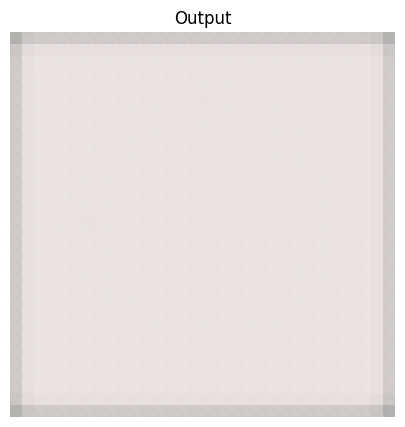

In [26]:
output_image = outputs_pred
output_image = outputs_pred.detach().cpu().numpy().transpose(1, 2, 0)
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

# Display the one-hot color (display the active channel as a binary image)
axes.imshow(output_image)
axes.set_title("Output")
axes.axis('off')
